<center><h1> Wrangling and Analyzing @WeRateDogs Twitter Archive

<div style="text-align: right">
    Parth Thakur<br>
    11/09/2018<br>
    <a href=https://github.com/ParthThakur/Wrangling-and-Analyzing-WeRateDogs-twitter-archive>Github</a>
    <a href=https://www.linkedin.com/in/parth-thakur>LinkedIn</a>
</div>

In this workbook, I will gather data on `@WeRateDogs` tweets and clean this data to perform some analysis. <br>

`@WeRateDogs` is a twitter account that rates dog pictures and videos. I have the archive data for this account, but it comes with various tidyness and Quality issues. The archive is also missing some crucial features. The goal of this project is to identify as many issues as possible and rectify the. 

In [1]:
# Import required libraries.

import numpy as np
import tweepy
import pandas as pd
import requests
import json
import re
import ast
import matplotlib.pyplot as plt

# Set font size at 15 for all plots.
plt.rcParams['font.size'] = 15 

# Show matplotlib plots in workbook.
%matplotlib inline

In [2]:
# Setup twitter API

with open('../API keys.json') as fo:
    d = fo.read()
    tw_keys = ast.literal_eval(d)['Twitter']

auth = tweepy.OAuthHandler(tw_keys['consumer_key'], tw_keys['consumer_secret'])
auth.set_access_token(tw_keys['access_token'], tw_keys['access_token_secret'])

api = tweepy.API(auth,
                wait_on_rate_limit=True,
                wait_on_rate_limit_notify=True)

In [3]:
# Function to load additional tweet data using twitter API.

def get_tweet_data():
    failed_tweets = {}
    print("Querying Twitter API.")
    with open("datasets/tweet_json.txt", "w") as fw:        
        for tweet in tw_archive.tweet_id:
            try:
                twee = api.get_status(tweet, tweet_mode='extended')
            except tweepy.TweepError as e:
                print(tweet, "failed to load.")
                failed_tweets[tweet] = repr(e)
                continue
            fw.write(json.dumps(twee._json))
            fw.write('\n')

    return failed_tweets
            

# Function to read tweet_json.txt.

def read_tweet_json():
    tweet_info = []
    print("Trying to open tweet_json.txt")
    with open("datasets/tweet_json.txt", "r") as fr:
        print("File found.")
        for tweet in fr:
            twee = json.loads(tweet)
            retweet_count = twee["retweet_count"]
            favourite_count = twee["favorite_count"]
            if twee["full_text"][:4] == "RT @":
                tweet_type = "retweet"
            elif twee["full_text"][0] == "@":
                tweet_type = "reply"
            else:
                tweet_type = "original"
            tweet_info.append({"tweet_id": str(twee["id"]),
                              "retweet_count": int(retweet_count),
                              "favourite_count": int(favourite_count),
                              "tweet_type": tweet_type})
    tweet_info = pd.DataFrame(tweet_info, columns=["tweet_id", "retweet_count", "favourite_count", "tweet_type"])
    
    return tweet_info

In [4]:
# Class to embed tweets in the notebook.

class embed_tweet(object):
    def __init__(self, embed_code=None):
        self.embed_code = embed_code

    def _repr_html_(self):
        return self.embed_code

# Gather

Gathering all the required data programitacally. 

In [5]:
# Load the twitter archive data for @WeRateDogs.

tw_archive = pd.read_csv("datasets/raw/twitter-archive-enhanced.csv") 

In [6]:
# Get "image_predictions.tsv" from Udacity's servers and load the data in a DataFrame

URL_predict = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
im_get = requests.get(URL_predict)
with open("datasets/raw/image_predictions.tsv", "wb") as fw:
    fw.write(im_get.content)    

In [7]:
# Load image prediction Data from image_predictions.tsv

im_predict = pd.read_csv("datasets/raw/image_predictions.tsv", delimiter="\t")

In [8]:
# Load additional tweet data from "tweet_json.txt".
try:
    tweet_info = read_tweet_json()
except FileNotFoundError:
    print("tweet_json.txt was not found.")
    failed_tweets = get_tweet_data()
    tweet_info = read_tweet_json()
    with open ("failed_tweets.json", "w") as fw:
        json.dump(failed_tweets, fw)

Trying to open tweet_json.txt
File found.



# Assess
Assessing the gathered data for quality, and tidyness issues.

I have three dasets loaded into pandas dataframes.
 - tw_archive which contains archive data for WeRateDogs twitter account.
 - im_predict which contains data on predicted dog species in the tweet.
 - tweet_info which contains additional data on the tweets.

In [9]:
tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
im_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [11]:
tw_archive.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
576,800859414831898624,8.008580e+17,291859009.0,2016-11-22 00:32:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@SkyWilliams doggo simply protecting you from ...,NaN,NaN,NaN,NaN,11,10,None,doggo,None,None,None
2097,670733412878163972,NaN,NaN,2015-11-28 22:38:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's a great listener. Low main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670733412...,8,10,Jerry,None,None,None,None
1155,724983749226668032,NaN,NaN,2016-04-26 15:29:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Fred-Rick. He dabbles in parkour. The ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/724983749...,12,10,Fred,None,None,None,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
1636,684200372118904832,NaN,NaN,2016-01-05 02:30:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Gang of fearless hoofed puppers here. Straight...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684200372...,6,10,None,None,None,None,None
919,756526248105566208,NaN,NaN,2016-07-22 16:28:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",All hail sky doggo. 13/10 would jump super hig...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/756526248...,13,10,None,doggo,None,None,None
490,813812741911748608,NaN,NaN,2016-12-27 18:24:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Gary, Carrie Fisher's dog. Idk what I can...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/813812741...,14,10,Gary,None,None,None,None
643,793195938047070209,NaN,NaN,2016-10-31 21:00:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lily. She's pupset that her costu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793195938...,12,10,Lily,None,None,None,puppo
1902,674644256330530816,NaN,NaN,2015-12-09 17:38:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you see sophomores in high school driving...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674644256...,11,10,None,None,None,None,None
592,798933969379225600,NaN,NaN,2016-11-16 17:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Iroh. He's in a predicament. 12/10 som...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/798933969...,12,10,Iroh,None,None,None,None


In [12]:
im_predict.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
89,667534815156183040,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,1,Pembroke,0.435254,True,Cardigan,0.307407,True,cocker_spaniel,0.033158,True
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,0.278407,True,groenendael,0.102643,True
1144,730211855403241472,https://pbs.twimg.com/media/CiI7zVZUoAEzGW7.jpg,1,pug,0.341663,True,Norwegian_elkhound,0.171222,True,German_shepherd,0.124687,True
41,666701168228331520,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,1,Labrador_retriever,0.887707,True,Chihuahua,0.029307,True,French_bulldog,0.020756,True
1082,718454725339934721,https://pbs.twimg.com/media/Cfh2w6HWIAIIYAF.jpg,1,hammer,0.169865,False,hatchet,0.115744,False,chime,0.068092,False
180,669327207240699904,https://pbs.twimg.com/media/CUntin8WIAADmLk.jpg,1,golden_retriever,0.919584,True,Labrador_retriever,0.049669,True,kuvasz,0.010216,True
969,706516534877929472,https://pbs.twimg.com/media/Cc4NCQiXEAEx2eJ.jpg,1,golden_retriever,0.772685,True,Labrador_retriever,0.071665,True,golfcart,0.020993,False
1332,757725642876129280,https://pbs.twimg.com/media/CoP7c4bWcAAr55g.jpg,2,seat_belt,0.425176,False,Labrador_retriever,0.128128,True,Siamese_cat,0.091241,False
720,685943807276412928,https://pbs.twimg.com/ext_tw_video_thumb/68594...,1,papillon,0.200812,True,toy_terrier,0.114512,True,Cardigan,0.094520,True


In [13]:
tw_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
tw_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [15]:
tw_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

### Quality:

##### `tw_archive` table:
 - `rating_denominator` is not always 10.
 - `rating_numerator` is not always greater than 10.
 - `expanded_url` contain duplicate data sometimes.
 - `name` is sometimes missing or a preposition. _(Can't fix missing names.)_
 - `expanded_url` sometimes missing.
 - No column to determine type of tweet; i.e. Original, Retweet, or Reply.
 - `dog_stage` sometimes missing. _(Can't fix currently.)_
 - Some column headers aren't very descriptive.
 
 
##### `im_predict` table:
 - Underscore (\_) between words.
 - Some tweets contain no dogs.

### Tidiness:

##### `tw_archive` table:
 - Missing values are "None".
 - Single variable `dog_stage` in four seperate columns.
 - Multiple `dog_stage` in some tweets.
 - Short URL is in `text` column.
 - `source` has full links.
 - `tweet_id`, `timestamp`, `retweeted_status_timestamp` columns are int64.
 
##### `im_predict` table:
 - `p1`, `p2`, `p3`, are objects.

# Clean
Cleaning the issues found in the assessment section.

In [16]:
# Create copies of original dataset for cleaning.

tw_archive_clean = tw_archive.copy()
im_predict_clean = im_predict.copy()

##### Define:
`tweet_id` in both tables is `int64`. Since I am nott going to perform any mathematical operatioons on the, convert them to `str`.

##### Code:

In [17]:
tw_archive_clean.tweet_id = tw_archive_clean.tweet_id.astype("str")
im_predict_clean.tweet_id = im_predict_clean.tweet_id.astype("str")

##### Test:

In [18]:
tw_archive_clean.tweet_id.head(), im_predict_clean.tweet_id.head()

(0    892420643555336193
 1    892177421306343426
 2    891815181378084864
 3    891689557279858688
 4    891327558926688256
 Name: tweet_id, dtype: object, 0    666020888022790149
 1    666029285002620928
 2    666033412701032449
 3    666044226329800704
 4    666049248165822465
 Name: tweet_id, dtype: object)

### Missing data

`tw_archive` missing retweet count and favourite count.

##### Define:
The twitter-archive-enhanced.csv dataset did not have favourite count and retweet count for the tweet data. I gathered it using the Twitter API. Using the JSON data, I also determined if the tweet is an original, reply, or a retweet. <br>
Use `pandas.merge()` to mearge `tweet_info` with `tw_archive` to add this data to our dataset.


##### Code

In [19]:
tw_archive_clean = tw_archive_clean.merge(tweet_info, how="inner", on="tweet_id")

##### Test:

In [20]:
tw_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favourite_count,tweet_type
1719,679736210798047232,NaN,NaN,2015-12-23 18:51:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pup's name is Sabertooth (parents must be...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679736210...,9,10,None,None,None,None,None,864,2213,original
1635,683515932363329536,NaN,NaN,2016-01-03 05:11:12 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",HEY PUP WHAT'S THE PART OF THE HUMAN BODY THAT...,NaN,NaN,NaN,https://vine.co/v/ibvnzrauFuV,11,10,None,None,None,None,None,3153,7808,original
1855,675149409102012420,NaN,NaN,2015-12-11 03:05:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",holy shit 12/10 https://t.co/p6O8X93bTQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675149409...,12,10,None,None,None,None,None,1785,3886,original
2185,668655139528511488,NaN,NaN,2015-11-23 04:59:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Winifred. He is a Papyrus Hydrang...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668655139...,11,10,Winifred,None,None,None,None,227,546,original
855,761745352076779520,NaN,NaN,2016-08-06 02:06:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Guys.. we only rate dogs. Pls don't send any m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761745352...,11,10,None,None,None,None,None,940,4554,original
1721,679722016581222400,NaN,NaN,2015-12-23 17:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mike. He is a Jordanian Frito Pilates....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679722016...,8,10,Mike,None,None,None,None,509,1748,original
2252,667524857454854144,NaN,NaN,2015-11-20 02:08:22 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Another topnotch dog. His name is Big Jumpy Ra...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667524857...,12,10,None,None,None,None,None,1146,1727,original
807,770293558247038976,NaN,NaN,2016-08-29 16:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jackson. There's nothing abnormal abou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770293558...,10,10,Jackson,None,None,None,None,1643,6701,original
2111,670338931251150849,NaN,NaN,2015-11-27 20:30:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Butters. He's not ready for Thanksgivi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670338931...,10,10,Butters,None,None,None,None,117,438,original
820,768473857036525572,NaN,NaN,2016-08-24 15:43:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Chevy. He had a late breakfast and now ha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/768473857...,11,10,Chevy,None,None,None,None,3777,14626,original


### Tidiness

##### Define
The dataset contsins "none" as as string object for missing values. Replace "None" for missing values in `tw_archive` with `np.NaN`

##### Code:

In [21]:
tw_archive_clean.replace(to_replace="None", value=np.NaN, inplace=True)

##### Test:

In [22]:
tw_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favourite_count,tweet_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN,8444,38430,original
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN,6224,32923,original
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN,4125,24810,original
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN,8578,41779,original
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN,9307,39944,original


##### Define:

Use pandas.melt function to get a single variable `dog_stage` from the four variables.

In [23]:
dog_stage_df = pd.melt(tw_archive_clean, id_vars=["tweet_id"], 
                    value_vars=["doggo", "floofer", "pupper", "puppo"],
                   value_name="dog_stage").dropna().drop("variable", axis=1)
tw_archive_clean = tw_archive_clean.merge(dog_stage_df, on="tweet_id", how="left")
tw_archive_clean.dog_stage = tw_archive_clean.dog_stage.astype('category')
tw_archive_clean.drop(["doggo", "floofer", "pupper", "puppo"], axis=1, inplace=True)


##### Test:

In [24]:
tw_archive_clean.dog_stage.value_counts()

pupper     255
doggo       96
puppo       30
floofer     10
Name: dog_stage, dtype: int64

##### Define:
Some tweets had multiple dog stages. This might have happened if the tweet contained two or more of the keywords. As it is very difficult to determine where in the text the original dog stage might occur, consider the first stage as true and discard duplicates.

##### Code:

In [25]:
tw_archive_clean.drop_duplicates(subset="tweet_id", inplace=True)

##### Test:

In [26]:
tw_archive_clean.duplicated(subset=["tweet_id"]).any()

False

##### Define:
Short URL is with tweet text. Use Regular expressions to remove it from the text column and create a new `short_URL` column.

##### Code

In [27]:
s_url = re.compile(r"(https://t.co/.{10})")
tw_archive_clean["short_url"] = tw_archive_clean.text.str.extract(s_url)
tw_archive_clean.text = tw_archive_clean.text.str.replace(s_url, "")

##### Test:

In [28]:
tw_archive_clean[["tweet_id", "short_url", "text"]].sample(10)

,tweet_id,short_url,text
423,820837357901512704,NaN,RT @dog_rates: This is Finn. He's wondering if...
1280,708810915978854401,https://t.co/2KcuJXL2r4,This is Mister. He's a wonderful father to his...
531,806629075125202948,https://t.co/f1h2Fsalv9,"""Good afternoon class today we're going to lea..."
193,854365224396361728,https://t.co/mdaQhhfpv6,This is Einstein. He's having a really good da...
1647,683773439333797890,https://t.co/qipZbshNsR,This is Buddy. He's gaining strength. Currentl...
914,756939218950160384,https://t.co/KGdeHuFJnH,This is Jax. He is a majestic mountain pupper....
1463,694356675654983680,https://t.co/SQsEBWxPyG,This pupper only appears through the hole of a...
1497,692417313023332352,https://t.co/VGaIMktX10,Meet Herschel. He's slightly bigger than ur av...
616,796116448414461957,https://t.co/7i0bDMbrVN,I didn't believe it at first but now I can see...
1394,699801817392291840,https://t.co/qI8yvqKG02,This is Cooper. He began to tear up when his b...


##### Define
Some columns in the tables are of incorrect datatypes. Correct them as follows: <br>

`tw_archive` table:<br>
 - `timestamp`: DateTime<br>
 - `retweeted_status_timestamp`: DateTime<br>
 
`im_predict` table:<br>
 - `p1`, `p2`, `p3`: Category

In [29]:
tw_archive_clean.timestamp = pd.to_datetime(tw_archive_clean.timestamp)
tw_archive_clean.retweeted_status_timestamp = pd.to_datetime(tw_archive_clean.retweeted_status_timestamp)

In [30]:
im_predict_clean.p1 = im_predict_clean.p1.astype('category')
im_predict_clean.p2 = im_predict_clean.p2.astype('category')
im_predict_clean.p3 = im_predict_clean.p3.astype('category')

##### Test:

In [31]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 0 to 2354
Data columns (total 18 columns):
tweet_id                      2341 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2341 non-null datetime64[ns]
source                        2341 non-null object
text                          2341 non-null object
retweeted_status_id           167 non-null float64
retweeted_status_user_id      167 non-null float64
retweeted_status_timestamp    167 non-null datetime64[ns]
expanded_urls                 2282 non-null object
rating_numerator              2341 non-null int64
rating_denominator            2341 non-null int64
name                          1604 non-null object
retweet_count                 2341 non-null int64
favourite_count               2341 non-null int64
tweet_type                    2341 non-null object
dog_stage                     377 non-null category
short_url       

In [32]:
im_predict_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null category
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null category
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null category
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), category(3), float64(3), int64(1), object(2)
memory usage: 174.9+ KB


##### Define:
Source of the tweet has has the entire HTML tag. Remove the redundant tags and only keep the text. `source` is also not very descriptive, so change column name to `tweet_source`.

##### Code:

In [33]:
source_regex = re.compile(r">(.+)<")
tw_archive_clean["tweet_source"] = tw_archive_clean.source.str.extract(source_regex)
tw_archive_clean.drop("source", axis=1, inplace=True)

##### Test:

In [34]:
tw_archive_clean[["tweet_id", "tweet_source"]].sample(10)

,tweet_id,tweet_source
1959,673363615379013632,Twitter for iPhone
89,874680097055178752,Twitter for iPhone
2208,668623201287675904,Twitter for iPhone
1539,689659372465688576,Twitter for iPhone
538,805932879469572096,Twitter for iPhone
637,793210959003287553,Twitter for iPhone
765,777621514455814149,Twitter for iPhone
473,815736392542261248,Twitter for iPhone
656,791026214425268224,Twitter for iPhone
2047,671511350426865664,Twitter for iPhone


### Quality

##### Define:
Some tweets have other fractions in the text. Use better regex to correct errors in rating_numerator and rating_denominator.

##### Code:

In [35]:
rating_num_regex = re.compile(r"(\d+\.?\d?)\/\d\d\d?")
rating_den_regex = re.compile(r"\d+\.?\d?\/(\d\d\d?)")
tw_archive_clean.rating_numerator = tw_archive_clean.text.str.extract(rating_num_regex).astype("int32", errors="ignore")
tw_archive_clean.rating_denominator = tw_archive_clean.text.str.extract(rating_den_regex).astype("int32", errors="ignore")


##### Test:

In [36]:
tw_archive_clean.rating_numerator.value_counts()

12      553
11      464
10      461
13      345
9       158
8       102
7        54
14       51
5        35
6        32
3        19
4        17
2         9
1         8
15        2
75        2
0         2
420       2
007       1
204       1
1776      1
60        1
45        1
26        1
44        1
27        1
84        1
20        1
666       1
80        1
88        1
143       1
960       1
13.5      1
121       1
9.5       1
17        1
99        1
50        1
144       1
165       1
182       1
Name: rating_numerator, dtype: int64

##### Define:
`name` is sometimes an article or a preposition. Replace these with blanks.<br>
`name` is also not a descriptive column header. Replace with `dog_name`.

##### Code

In [37]:
bad_dog_names = ["a", "with", "an", "the", "all", 'Hk']
dog_name_regex = r"(?:^|(?<= ))" + r'|'.join(bad_dog_names) + r"(?:(?= )|$)"
tw_archive_clean["dog_name"] = tw_archive_clean.name.str.replace(dog_name_regex, str(np.nan), regex=True)
tw_archive_clean.drop("name", axis=1, inplace=True) 

##### Test

In [38]:
tw_archive_clean.dog_name.isin(bad_dog_names).any()

False

##### Define:
`expanded_urls` sometimes have duplicated urls present seperated by commas. Since commas arent normally used in urls, everything after the comma, including it is deleted.

In [39]:
tw_archive_clean.iloc[4].expanded_urls

'https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1'

##### Code:

In [40]:
tw_archive_clean.expanded_urls = tw_archive_clean.expanded_urls.str.replace(r",.+", "", regex=True)

##### Test:


In [41]:
tw_archive_clean.iloc[4].expanded_urls

'https://twitter.com/dog_rates/status/891327558926688256/photo/1'

##### Define:
The `expanded_url` is missing for some tweets. Use the requests library to get the full URL of the tweet. The requests library will also handle any redirects that occur and give us the final URL.

##### Code:

In [42]:
null_expn_urls = tw_archive_clean[pd.isnull(tw_archive_clean.expanded_urls)]["tweet_id"].tolist()
t_url = r"https://twitter.com/dog_rates/status/"

for tweet in null_expn_urls:
    response = requests.get(t_url + str(tweet))
    tw_archive_clean.loc[tw_archive_clean["tweet_id"]==tweet, "expanded_urls"] = response.url

##### Test:

In [43]:
pd.isnull(tw_archive_clean.expanded_urls).any()

False

##### Define:
The words in `p1`, `p2`, `p3`, columns in `im_predict` table are seperated by underscores (\_). Replace the underscores with spaces. <br>
The first letters of each word should also be be capatalised for consistency.

##### Code:

In [44]:
im_predict_clean.p1 = im_predict_clean.p1.str.replace(r"_", " ", regex=True).str.title()
im_predict_clean.p2 = im_predict_clean.p2.str.replace(r"_", " ", regex=True).str.title()
im_predict_clean.p3 = im_predict_clean.p3.str.replace(r"_", " ", regex=True).str.title()

##### Test:

In [45]:
im_predict_clean[["p1", "p2", "p3"]].sample(10)

,p1,p2,p3
1754,Border Terrier,Malinois,Airedale
286,Rottweiler,Black-And-Tan Coonhound,Kelpie
1750,Schipperke,Curly-Coated Retriever,Labrador Retriever
11,Gordon Setter,Yorkshire Terrier,Pekinese
195,Candle,Lampshade,Plunger
870,Washbasin,Paper Towel,Toilet Tissue
1603,Golden Retriever,Kuvasz,Labrador Retriever
85,Beagle,Labrador Retriever,Golden Retriever
980,Bernese Mountain Dog,Shetland Sheepdog,Appenzeller
276,Shih-Tzu,Lhasa,Guinea Pig


##### Define:
Rating numerator for tweet_id 695064344191721472 and 722974582966214656 is 13 and not 4.

##### Code:

In [46]:
tw_archive_clean.loc[tw_archive_clean.tweet_id == "695064344191721472", "rating_numerator"] = 13
tw_archive_clean.loc[tw_archive_clean.tweet_id == "722974582966214656", "rating_numerator"] = 13

##### Test:

In [47]:
tw_archive_clean.loc[tw_archive_clean.tweet_id.isin(["695064344191721472", "722974582966214656"])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,retweet_count,favourite_count,tweet_type,dog_stage,short_url,tweet_source,dog_name
1164,722974582966214656,NaN,NaN,2016-04-21 02:25:47,Happy 4/20 from the squad! 13/10 for all,NaN,NaN,NaT,https://twitter.com/dog_rates/status/722974582...,13,20,1695,4340,original,NaN,https://t.co/eV1diwds8a,Twitter for iPhone,NaN
1458,695064344191721472,NaN,NaN,2016-02-04 02:00:27,This may be the greatest video I've ever been ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/695064344...,13,10,652,1707,original,NaN,https://t.co/uaJmNgXR2P,Twitter for iPhone,NaN


Going forward, I need a combined dataset of `tw_archive_clean` and `im_predict_clean`. There's also some columns in the `tw_archive_clean` dataset that arent necessary for our analysis. <br>
These columns are not necessarily useless, so I will first save the cleaned tables as csv files. While combining the datasets, I'd like to only get tweets that are of dogs. All other tweets are not needed and will be dropped.

In [48]:
tw_archive_clean.to_csv("datasets/cleaned/twitter-archive-cleaned.csv", index=False)
im_predict_clean.to_csv("datasets/cleaned/image-predictions-cleaned.csv", index=False)

In [49]:
tw_archive_clean = pd.read_csv("datasets/cleaned/twitter-archive-cleaned.csv")
im_predict_clean = pd.read_csv("datasets/cleaned/image-predictions-cleaned.csv")

##### Define:
The datasets contain columns that are not required for our analysis. I will drop all such columns.<br>
`tw_archive` table:
 - expanded_urls
 - in_reply_to_status_id
 - in_reply_to_user_id
 - rating_denominator
 - retweeted_status_id
 - retweeted_status_user_id
 - retweeted_status_timestamp
 - tweet_type
 - short_url
 - tweet_source
 
Also, any tweet that is not "original" is not required. Therefore drop all retweets and replies.

##### Code:

In [50]:
tw_archive_clean = tw_archive_clean[tw_archive_clean.tweet_type == "original"]
tw_archive_clean.drop(["expanded_urls",
                       "in_reply_to_status_id",
                       "in_reply_to_user_id",
                       "rating_denominator",
                       "retweeted_status_id",
                       "retweeted_status_user_id",
                       "retweeted_status_timestamp",
                       "tweet_type",
                       "short_url",
                       "tweet_source"], axis=1, inplace=True)


##### Test:

In [51]:
tw_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2340
Data columns (total 8 columns):
tweet_id            2151 non-null int64
timestamp           2151 non-null object
text                2151 non-null object
rating_numerator    2150 non-null float64
retweet_count       2151 non-null int64
favourite_count     2151 non-null int64
dog_stage           342 non-null object
dog_name            1431 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 151.2+ KB


##### Define
the im_predict table contain no dogs at all. 
The `im_predict` table contains predictions of dog breeds contained in the media. It also contains tweets with no dogs at all. As I am interested in dogs only, I will only add the dog breed with the highest confidence value; i.e. the p_conf values of each prediction.

##### Code:

In [52]:
im_predict_clean = im_predict_clean[im_predict_clean[["p1_dog", "p2_dog", "p3_dog"]].any(axis=1)]
dog_breed_list = []
for index, tweet in im_predict_clean.iterrows():
    if tweet.p1_dog:
        dog_breed = tweet.p1
        conf = tweet.p1_conf

    elif tweet.p2_dog:
        dog_breed = tweet.p2
        conf = tweet.p2_conf
        
    elif tweet.p3_dog:
        dog_breed = tweet.p3
        conf = tweet.p3_conf
        
    dog_breed_list.append({"tweet_id": tweet.tweet_id,
                           "dog_breed": dog_breed,
                           "breed_confidence": conf,
                           "jpg_url": tweet.jpg_url})
dog_breed_df = pd.DataFrame(dog_breed_list, columns=["tweet_id", "dog_breed", "breed_confidence", "jpg_url"])

##### Test

In [53]:
dog_breed_df.head(10)

,tweet_id,dog_breed,breed_confidence,jpg_url
0,666020888022790149,Welsh Springer Spaniel,0.465074,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,666029285002620928,Redbone,0.506826,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,666033412701032449,German Shepherd,0.596461,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
3,666044226329800704,Rhodesian Ridgeback,0.408143,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
4,666049248165822465,Miniature Pinscher,0.560311,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
5,666050758794694657,Bernese Mountain Dog,0.651137,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg
6,666055525042405380,Chow,0.692517,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg
7,666057090499244032,Golden Retriever,0.007959,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg
8,666058600524156928,Miniature Poodle,0.201493,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg
9,666063827256086533,Golden Retriever,0.775930,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg


##### Define:
Create a `tw_archive_master` table with all the important columns. Use inner join on the `tw_archive` table and ``dog_breed_df` table

##### Code:

In [54]:
tw_archive_master = tw_archive_clean.merge(dog_breed_df, how="inner", on="tweet_id")
tw_archive_master.tweet_id = tw_archive_master.tweet_id.astype(str)
tw_archive_master = tw_archive_master[['timestamp',
                                       'dog_name', 
                                       'rating_numerator', 
                                       'dog_breed', 
                                       'dog_stage',
                                       'tweet_id',
                                       'text', 
                                       'retweet_count', 
                                       'favourite_count', 
                                       'breed_confidence', 
                                       'jpg_url']]

##### Test:

In [55]:
tw_archive_master.head()

,timestamp,dog_name,rating_numerator,dog_breed,dog_stage,tweet_id,text,retweet_count,favourite_count,breed_confidence,jpg_url
0,2017-08-01 00:17:27,Tilly,13.0,Chihuahua,NaN,892177421306343426,This is Tilly. She's just checking pup on you....,6224,32923,0.323581,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,2017-07-31 00:18:03,Archie,12.0,Chihuahua,NaN,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,4125,24810,0.716012,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,2017-07-30 15:58:51,Darla,13.0,Labrador Retriever,NaN,891689557279858688,This is Darla. She commenced a snooze mid meal...,8578,41779,0.168086,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,2017-07-29 16:00:24,Frnanklin,12.0,Basset,NaN,891327558926688256,This is Franklin. He would like you to stop ca...,9307,39944,0.555712,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,2017-07-29 00:08:17,NaN,13.0,Chesapeake Bay Retriever,NaN,891087950875897856,Here we have a majestic great white breaching ...,3085,20052,0.425595,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


Saving the cleaned and combined data in a master csv file

In [56]:
tw_archive_master.to_csv("datasets/cleaned/twitter_archive_master.csv", index=False, index_label=False)

This concludes the Data Wrangling process. I now have a dataframe with clean, tidy data which can be analysed without troubles.

# Analyze

In [57]:
df = pd.read_csv("datasets/cleaned/twitter_archive_master.csv").set_index("tweet_id")
df.dog_stage = df.dog_stage.astype('category')
df.timestamp = pd.to_datetime(df.timestamp)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 892177421306343426 to 666020888022790149
Data columns (total 10 columns):
timestamp           1685 non-null datetime64[ns]
dog_name            1213 non-null object
rating_numerator    1684 non-null float64
dog_breed           1685 non-null object
dog_stage           260 non-null category
text                1685 non-null object
retweet_count       1685 non-null int64
favourite_count     1685 non-null int64
breed_confidence    1685 non-null float64
jpg_url             1685 non-null object
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 133.5+ KB


Let me first check some descriptive statistics on the important columns.

In [59]:
df.describe()

,rating_numerator,retweet_count,favourite_count,breed_confidence
count,1684.000000,1685.000000,1685.000000,1685.000000
mean,11.481295,2739.234421,9136.265875,0.549905
std,8.098699,4930.073043,13283.783281,0.299357
min,0.000000,12.000000,80.000000,0.000010
25%,10.000000,614.000000,2086.000000,0.302685
50%,11.000000,1369.000000,4294.000000,0.550506
75%,12.000000,3104.000000,11312.000000,0.822048
max,165.000000,84548.000000,164603.000000,0.999956


In [60]:
df.dog_name.value_counts().nlargest(5)

Lucy       10
Cooper     10
Charlie     9
Oliver      9
Tucker      9
Name: dog_name, dtype: int64

In [61]:
df.dog_breed.value_counts().nlargest(5)

Golden Retriever      158
Labrador Retriever    108
Pembroke               95
Chihuahua              91
Pug                    62
Name: dog_breed, dtype: int64

There are a few that things that become apparent here.

1. The five most common dog names are:
    - Cooper
    - Lucy
    - Charlie
    - Oliver
    - Tucker
    
    
2. The five most common dog breeds are:
    - Golden Retriever
    - Labrador Retriever
    - Pembroke
    - Chihuahua
    - Pug
    
    
3. There are a few outliers on in both rating numerator, rating denominator. 
   Most interestingly, there are a few ratings below 10.
   
4. Least amount of retweets are 12, while the maximum is 84,113.

5. Least amount of favourites is 80, while the maximum is 161,869.

### Some Questions:
    
    Why was a dog rated 0, and which dog got a rating of 165?
    Who is twitter's most favorite dog, and did it get the maximum retweets as 
    well?
    Which dog breed is Twitter's most favourite, and are they also rated the highest?

First let us take a look at the tweet which rated a dog 0.

In [62]:
# Get the html code to embed tweet using the oembed API from twitter.
# Then display the tweet as an html object using the embed_tweet class defined earlier.

dog0_index = df.loc[df.rating_numerator == 0].index.values[0]
dog0_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog0_index)).json()["html"]
embed_tweet(dog0_tweet)

Looks like the tweet is about plagiarism, and no dogs have been given a rating 
of 0. <br>
Now, which dog has a rating of 165?

In [63]:
dog165_index = df.loc[df.rating_numerator == 165].index.values[0]
dog165_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog165_index)).json()["html"]
embed_tweet(dog165_tweet)

Looks like it's a bunch of dogs at the ownwer's front door. Truely adorable and 
worthy of such a high rating!

Who is twitter's most favourite dog?


In [64]:
dog_favourite_index = df.loc[df.favourite_count == max(df.favourite_count)].index.values[0]
dog_favourite_tweet = requests.get("https://api.twitter.com/1.1/statuses/oembed.json?id=" + str(dog_favourite_index)).json()["html"]
embed_tweet(dog_favourite_tweet)

Did this dog also get the maximum retweets?

In [65]:
 (df.loc[df.favourite_count == max(df.favourite_count)].dropna(axis=1) == df.loc[df.retweet_count == max(df.retweet_count)].dropna(axis=1)).all(axis=1)

tweet_id
744234799360020481    True
dtype: bool

He is! What an adorable realisation indeed.

Let's check some relationships between the data. I'd like to know which breed of dog is favourited the most. To see this, I'll add the `favourite_count` for all breeds. As there are more than 100 breeds in the dataset, I'll only take a look at the top 10 most common breeds. The rest of the breeds will be tagged as `others`.

In [66]:
# Make new column in dataset to indicate top 10 most common breed.
# Then use the new column to get the sum of all other values grouped by the new catagories.

df.dog_breed = df.dog_breed.astype("category")
breed_top10 = df.dog_breed.value_counts().nlargest(10).index.tolist()
df["breed_top10"] = np.where(df.dog_breed.isin(breed_top10), df.dog_breed, "other")
df.breed_top10 = df.breed_top10.astype("category")

x = df.groupby("breed_top10").sum()  # `x` holds the "sum" dataset.
x.index.name = "Breeds"

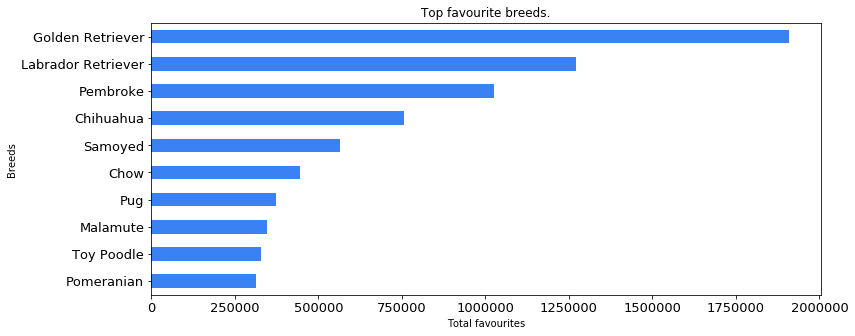

In [69]:
# Plot "sum of favourite_count" by "dog_breed". Sort the data to make the plot more readable.
# Dropped "other" category as the value will be large and skew the plot.

x.sort_values(by=["favourite_count"], inplace=True)
plt.xlabel("Total favourites")
x.drop("other")["favourite_count"].plot(kind="barh", color='#3A82F4', fontsize=13,
                          title="Top favourite breeds.",
                          figsize=(12,5))

It looks like Twitter likes Golden Retrievers the most with about 2,000,000 favourites, followed by Labrador Retrievers at around 1,500,000 favourites.

Finally, let me look at the top rated dogs.

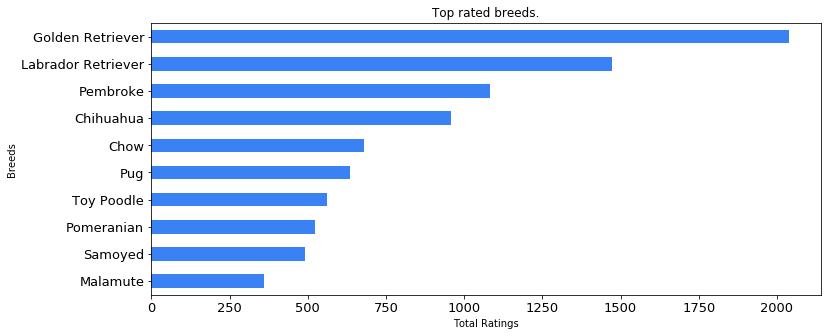

In [68]:
# Plot "sum of rating_numerator" vs "dog_breed".

x.sort_values(by=["rating_numerator"], inplace=True)
plt.xlabel("Total Ratings")
x.drop("other")["rating_numerator"].plot(kind="barh", color='#3A82F4', fontsize=13,
                          title="Top rated breeds.",
                          figsize=(12,5))

I guess it's not a surprise that the most favourited dogs will also be the top rated dogs.

This concludes my report on wrangling and analysing @WeRateDogs twitter archive data.

##### References:

    https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o
    https://docs.python.org/2/library/json.html
    https://developer.twitter.com/en/docs/tweets/post-and-engage/api-reference/get-statuses-oembed.html
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html  
    https://regexone.com/
    